## Classification Algorithms - Sample 

In [1]:
#import libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

#must enabel hist gradient boosting before importing
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize

from xgboost import XGBClassifier # pip install xgboost

from lightgbm import LGBMClassifier  #conda install -c conda-forge lightgbm
from catboost import CatBoostClassifier


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 
from cycler import cycler



In [2]:
def evaluate_classification_model(actual_result, predicted_result, predicted_probability_result,classes):
    print('accuracy score : \n', accuracy_score(actual_result, predicted_result))
    print('confusion matrix \n', confusion_matrix(actual_result, predicted_result))
    print('classification report \n', classification_report(actual_result, predicted_result))
    
    #AUROC curve 
    rows_count = len(actual_result)
    class_count = len(classes)
    #prepare reference result where size is rows_count * class_count
    reference_result = np.zeros( rows_count * class_count).reshape(rows_count, class_count)
    #fill each row's cell with 1/class count. so total value of each row will be 1. 
    reference_result.fill(1/class_count)
    
    #prepare binarized actual result 
    actual_result_binarized = label_binarize(actual_result, classes)
    
    #only one reference score and curve is sufficient. 
    ref_roc_auc_score = roc_auc_score(actual_result, reference_result, multi_class='ovo', average='weighted')
    ref_fpr, ref_tpr, ref_th = roc_curve(actual_result_binarized[:,0], reference_result[:,0])
    
    plt.plot(ref_fpr, ref_tpr, color='blue', label='reference score : {}'.format(ref_roc_auc_score * 100))
    
    plt.rc('axes', prop_cycle=(cycler('color', ['r','g','b','y']) 
                               + cycler('linestyle',['-','--',':','-.'])
                              ))
    
    for count in range(class_count):
        act_roc_auc_score = roc_auc_score(actual_result_binarized[:, count], predicted_probability_result[:, count], 
                                         multi_class='ovo', average='weighted')
        act_fpr, act_tpr, act_th = roc_curve(actual_result_binarized[:, count], predicted_probability_result[:,count])
        plt.plot(act_fpr, act_tpr, label='roc cuve for class : {}. score : {} '.format(classes[count], act_roc_auc_score))
        
    
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('roc curve for classification')
    plt.legend()
    plt.show()
    


In [3]:
def create_and_train_model(dataset, predictors, target, model_name):
    model = None
    if (model_name == 'knn'):
        model = KNeighborsClassifier()
    elif (model_name == 'decision-tree'):
        model = DecisionTreeClassifier()
    elif (model_name == 'extra-tree-classifier'):
        model = ExtraTreeClassifier()
    elif (model_name == 'logistic-classifier'):
        model = LogisticRegression()
    elif (model_name == 'svm'):
        model = LinearSVC()  
    elif (model_name == 'random-forest'):
        model = RandomForestClassifier()
    elif (model_name == 'bagging-classifier'):
        model = BaggingClassifier()
    elif (model_name == 'naive-bayes'):
        model = GaussianNB()
    elif (model_name == 'gradient-boosting'):
        model = GradientBoostingClassifier()
    elif (model_name == 'extreme-gradient-boosting'):
        model = XGBClassifier()
    elif (model_name == 'hist-boosting'):
        model = HistGradientBoostingClassifier()
    elif (model_name == 'ada-boosting'):
        model = AdaBoostClassifier()
    elif (model_name == 'light-gbm'):
        model = LGBMClassifier()
    elif (model_name == 'cat-boosting'):
        model = CatBoostClassifier()
    else:
        print('Unsupported Model! returns None')
        
    model.fit(dataset[predictors], dataset[target])
    return model

In [4]:
def create_train_predict_evaluate_single_model(dataset, predictors, target, classes, model_name):
    
    #prepare train and test datasts 
    skfold = StratifiedKFold(n_splits=3) # 33.33%
    train_dataset = None
    test_dataset = None
    for train_dataset_indexes, test_dataset_indexes in  skfold.split(dataset[predictors], dataset[target]):
        train_dataset = dataset.iloc[train_dataset_indexes]
        test_dataset = dataset.iloc[test_dataset_indexes]
        break
   
    #create and train model 
    model = create_and_train_model(train_dataset, predictors, target, model_name)
    
    #predict the results 
    predicted_result = model.predict(test_dataset[predictors])
    
    #predit probability
    if (model_name == 'svm'):
        predicted_result_probability = model.decision_function(test_dataset[predictors])
    else:
        predicted_result_probability = model.predict_proba(test_dataset[predictors])
    
    #evaluate the result 
    print('*******Evaluation Report for the model {}*************'.format(model_name))
    evaluate_classification_model(test_dataset[target], predicted_result, predicted_result_probability, classes)
    
    
        

In [5]:
def load_wine_dataset():
    wine_predictors = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
    wine_target = 'quality'
    wine_column_names = wine_predictors.copy(); wine_column_names.append(wine_target)
    
    wine_dataset = pd.read_csv('..\data\wine-quality\winequality-white.csv', sep=';', header=None, names=wine_column_names)
    
    wine_classes = np.unique(wine_dataset[wine_target])
    
    return wine_dataset, wine_predictors, wine_target, wine_classes
    
    

## Experiment Area

*******Evaluation Report for the model knn*************
accuracy score : 
 0.3851806491120637
confusion matrix 
 [[  0   3   1   2   0   0   0]
 [  1   6  19  27   2   0   0]
 [  1  26 214 215  27   3   0]
 [  2  19 284 366  55   7   0]
 [  0   0  87 163  43   0   0]
 [  0   0  17  32   9   0   0]
 [  0   0   0   2   0   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.11      0.11      0.11        55
           5       0.34      0.44      0.39       486
           6       0.45      0.50      0.48       733
           7       0.32      0.15      0.20       293
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         2

    accuracy                           0.39      1633
   macro avg       0.17      0.17      0.17      1633
weighted avg       0.37      0.39      0.37      1633



C:\Users\henci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


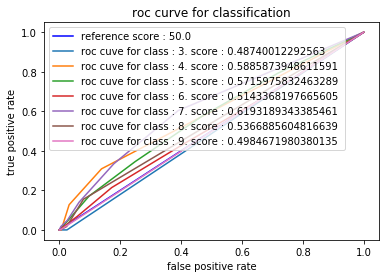

*******Evaluation Report for the model decision-tree*************
accuracy score : 
 0.41151255358236377
confusion matrix 
 [[  0   0   4   2   0   0   0]
 [  2  18  19  16   0   0   0]
 [  7  46 245 155  31   2   0]
 [  4  31 256 333  98   8   3]
 [  1  11  57 143  73   5   3]
 [  0   0   2  35  16   3   2]
 [  0   0   0   2   0   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.17      0.33      0.22        55
           5       0.42      0.50      0.46       486
           6       0.49      0.45      0.47       733
           7       0.33      0.25      0.29       293
           8       0.17      0.05      0.08        58
           9       0.00      0.00      0.00         2

    accuracy                           0.41      1633
   macro avg       0.23      0.23      0.22      1633
weighted avg       0.41      0.41      0.41      1633



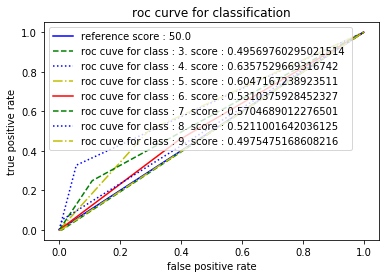

*******Evaluation Report for the model logistic-classifier*************
accuracy score : 
 0.4262094304960196
confusion matrix 
 [[  0   0   3   2   1   0   0]
 [  0   0  31  24   0   0   0]
 [  0   3 252 230   1   0   0]
 [  0   3 285 444   1   0   0]
 [  0   0  51 242   0   0   0]
 [  0   0   4  52   2   0   0]
 [  0   0   1   1   0   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        55
           5       0.40      0.52      0.45       486
           6       0.45      0.61      0.51       733
           7       0.00      0.00      0.00       293
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         2

    accuracy                           0.43      1633
   macro avg       0.12      0.16      0.14      1633
weighted avg       0.32      0.43      0.37      1633



C:\Users\henci\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\henci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


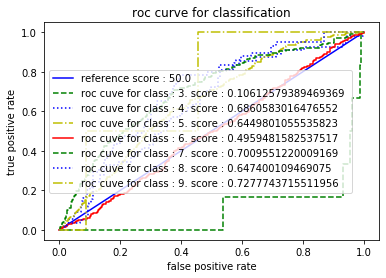

*******Evaluation Report for the model svm*************
accuracy score : 
 0.3968156766687079
confusion matrix 
 [[  0   0   3   3   0   0   0]
 [  0   1  48   6   0   0   0]
 [  0   0 392  94   0   0   0]
 [  0   0 479 252   0   2   0]
 [  0   0 107 183   3   0   0]
 [  0   0  18  40   0   0   0]
 [  0   0   0   2   0   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       1.00      0.02      0.04        55
           5       0.37      0.81      0.51       486
           6       0.43      0.34      0.38       733
           7       1.00      0.01      0.02       293
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         2

    accuracy                           0.40      1633
   macro avg       0.40      0.17      0.14      1633
weighted avg       0.52      0.40      0.33      1633



C:\Users\henci\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\henci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


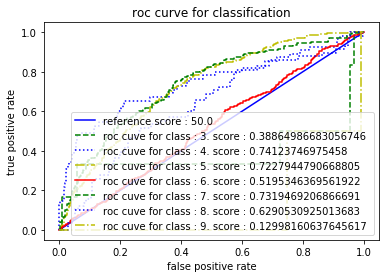

*******Evaluation Report for the model random-forest*************
accuracy score : 
 0.4941824862216779
confusion matrix 
 [[  0   0   3   3   0   0   0]
 [  0   5  35  15   0   0   0]
 [  0   8 330 146   2   0   0]
 [  0   3 277 435  18   0   0]
 [  0   1  31 225  36   0   0]
 [  0   0   3  45   9   1   0]
 [  0   0   0   1   1   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.29      0.09      0.14        55
           5       0.49      0.68      0.57       486
           6       0.50      0.59      0.54       733
           7       0.55      0.12      0.20       293
           8       1.00      0.02      0.03        58
           9       0.00      0.00      0.00         2

    accuracy                           0.49      1633
   macro avg       0.40      0.21      0.21      1633
weighted avg       0.51      0.49      0.45      1633



C:\Users\henci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


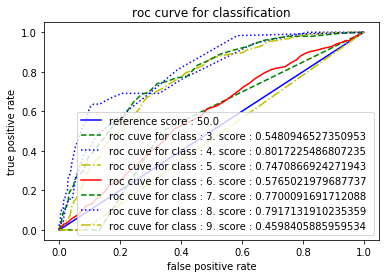

*******Evaluation Report for the model bagging-classifier*************
accuracy score : 
 0.451316595223515
confusion matrix 
 [[  0   0   2   4   0   0   0]
 [  1   9  32  13   0   0   0]
 [  1  21 306 145  12   1   0]
 [  0  13 312 370  38   0   0]
 [  0   0  56 185  51   1   0]
 [  0   2   7  37  11   1   0]
 [  0   0   1   1   0   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.20      0.16      0.18        55
           5       0.43      0.63      0.51       486
           6       0.49      0.50      0.50       733
           7       0.46      0.17      0.25       293
           8       0.33      0.02      0.03        58
           9       0.00      0.00      0.00         2

    accuracy                           0.45      1633
   macro avg       0.27      0.21      0.21      1633
weighted avg       0.45      0.45      0.43      1633



C:\Users\henci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


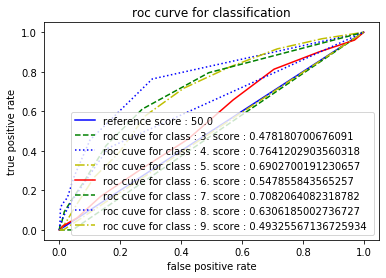

*******Evaluation Report for the model naive-bayes*************
accuracy score : 
 0.44335578689528476
confusion matrix 
 [[  0   2   1   2   1   0   0]
 [  2  15  19  15   4   0   0]
 [ 10  43 287 119  27   0   0]
 [  7  26 300 269 131   0   0]
 [  0   1  46  86 153   4   3]
 [  0   3   1  21  33   0   0]
 [  0   0   1   0   1   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.17      0.27      0.21        55
           5       0.44      0.59      0.50       486
           6       0.53      0.37      0.43       733
           7       0.44      0.52      0.48       293
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         2

    accuracy                           0.44      1633
   macro avg       0.22      0.25      0.23      1633
weighted avg       0.45      0.44      0.44      1633



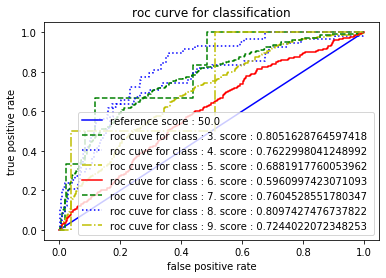

*******Evaluation Report for the model extra-tree-classifier*************
accuracy score : 
 0.4102878138395591
confusion matrix 
 [[  0   0   4   1   1   0   0]
 [  1   7  30  15   2   0   0]
 [  4  20 275 164  20   3   0]
 [  1  28 287 306  90  19   2]
 [  0   7  66 135  78   6   1]
 [  0   0   7  30  17   4   0]
 [  0   0   0   2   0   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.11      0.13      0.12        55
           5       0.41      0.57      0.48       486
           6       0.47      0.42      0.44       733
           7       0.38      0.27      0.31       293
           8       0.12      0.07      0.09        58
           9       0.00      0.00      0.00         2

    accuracy                           0.41      1633
   macro avg       0.21      0.21      0.21      1633
weighted avg       0.41      0.41      0.40      1633



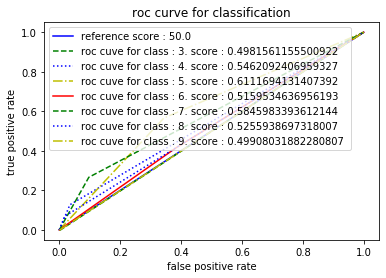

*******Evaluation Report for the model gradient-boosting*************
accuracy score : 
 0.45866503368034295
confusion matrix 
 [[  0   2   2   2   0   0   0]
 [  1   9  31  14   0   0   0]
 [  3  24 314 140   5   0   0]
 [  1   9 310 380  28   3   2]
 [  0   1  39 206  46   0   1]
 [  0   0   3  40  15   0   0]
 [  0   0   0   1   1   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.20      0.16      0.18        55
           5       0.45      0.65      0.53       486
           6       0.49      0.52      0.50       733
           7       0.48      0.16      0.24       293
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         2

    accuracy                           0.46      1633
   macro avg       0.23      0.21      0.21      1633
weighted avg       0.45      0.46      0.43      1633



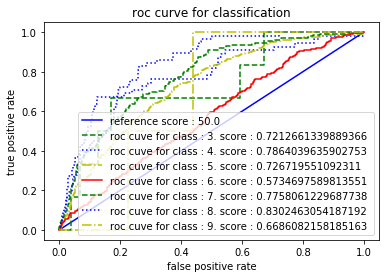

Learning rate set to 0.084049
0:	learn: 1.8120459	total: 174ms	remaining: 2m 54s
1:	learn: 1.7164668	total: 186ms	remaining: 1m 32s
2:	learn: 1.6312522	total: 193ms	remaining: 1m 4s
3:	learn: 1.5680770	total: 199ms	remaining: 49.6s
4:	learn: 1.5105433	total: 205ms	remaining: 40.7s
5:	learn: 1.4598690	total: 210ms	remaining: 34.8s
6:	learn: 1.4163341	total: 216ms	remaining: 30.6s
7:	learn: 1.3763245	total: 221ms	remaining: 27.5s
8:	learn: 1.3426382	total: 227ms	remaining: 25s
9:	learn: 1.3116548	total: 232ms	remaining: 23s
10:	learn: 1.2822790	total: 238ms	remaining: 21.4s
11:	learn: 1.2555365	total: 244ms	remaining: 20.1s
12:	learn: 1.2331529	total: 249ms	remaining: 18.9s
13:	learn: 1.2123726	total: 254ms	remaining: 17.9s
14:	learn: 1.1926451	total: 260ms	remaining: 17.1s
15:	learn: 1.1743849	total: 265ms	remaining: 16.3s
16:	learn: 1.1583626	total: 271ms	remaining: 15.7s
17:	learn: 1.1448303	total: 277ms	remaining: 15.1s
18:	learn: 1.1297150	total: 282ms	remaining: 14.6s
19:	learn: 1.

172:	learn: 0.7071100	total: 1.1s	remaining: 5.25s
173:	learn: 0.7070039	total: 1.1s	remaining: 5.23s
174:	learn: 0.7048190	total: 1.11s	remaining: 5.22s
175:	learn: 0.7030376	total: 1.11s	remaining: 5.21s
176:	learn: 0.7027400	total: 1.12s	remaining: 5.2s
177:	learn: 0.7010953	total: 1.12s	remaining: 5.19s
178:	learn: 0.6999116	total: 1.13s	remaining: 5.18s
179:	learn: 0.6988808	total: 1.14s	remaining: 5.18s
180:	learn: 0.6977382	total: 1.14s	remaining: 5.17s
181:	learn: 0.6965281	total: 1.15s	remaining: 5.16s
182:	learn: 0.6944619	total: 1.15s	remaining: 5.15s
183:	learn: 0.6930964	total: 1.16s	remaining: 5.14s
184:	learn: 0.6910226	total: 1.17s	remaining: 5.13s
185:	learn: 0.6899905	total: 1.17s	remaining: 5.13s
186:	learn: 0.6875348	total: 1.18s	remaining: 5.12s
187:	learn: 0.6861303	total: 1.18s	remaining: 5.11s
188:	learn: 0.6836196	total: 1.19s	remaining: 5.11s
189:	learn: 0.6826500	total: 1.2s	remaining: 5.1s
190:	learn: 0.6816184	total: 1.2s	remaining: 5.09s
191:	learn: 0.6801

336:	learn: 0.5320524	total: 2s	remaining: 3.93s
337:	learn: 0.5318795	total: 2s	remaining: 3.93s
338:	learn: 0.5304796	total: 2.01s	remaining: 3.92s
339:	learn: 0.5296669	total: 2.02s	remaining: 3.91s
340:	learn: 0.5285540	total: 2.02s	remaining: 3.91s
341:	learn: 0.5273940	total: 2.03s	remaining: 3.9s
342:	learn: 0.5257323	total: 2.03s	remaining: 3.89s
343:	learn: 0.5247270	total: 2.04s	remaining: 3.88s
344:	learn: 0.5240032	total: 2.04s	remaining: 3.88s
345:	learn: 0.5235361	total: 2.05s	remaining: 3.87s
346:	learn: 0.5221948	total: 2.05s	remaining: 3.86s
347:	learn: 0.5217011	total: 2.06s	remaining: 3.86s
348:	learn: 0.5207882	total: 2.06s	remaining: 3.85s
349:	learn: 0.5199525	total: 2.07s	remaining: 3.84s
350:	learn: 0.5186255	total: 2.08s	remaining: 3.84s
351:	learn: 0.5176394	total: 2.08s	remaining: 3.83s
352:	learn: 0.5166432	total: 2.08s	remaining: 3.82s
353:	learn: 0.5159288	total: 2.09s	remaining: 3.81s
354:	learn: 0.5148669	total: 2.1s	remaining: 3.81s
355:	learn: 0.514109

502:	learn: 0.4119856	total: 2.9s	remaining: 2.86s
503:	learn: 0.4111282	total: 2.9s	remaining: 2.86s
504:	learn: 0.4106497	total: 2.91s	remaining: 2.85s
505:	learn: 0.4101616	total: 2.92s	remaining: 2.85s
506:	learn: 0.4099115	total: 2.92s	remaining: 2.84s
507:	learn: 0.4093991	total: 2.93s	remaining: 2.83s
508:	learn: 0.4089185	total: 2.93s	remaining: 2.83s
509:	learn: 0.4082644	total: 2.94s	remaining: 2.82s
510:	learn: 0.4075529	total: 2.94s	remaining: 2.82s
511:	learn: 0.4073595	total: 2.95s	remaining: 2.81s
512:	learn: 0.4067676	total: 2.95s	remaining: 2.8s
513:	learn: 0.4059057	total: 2.96s	remaining: 2.8s
514:	learn: 0.4054933	total: 2.96s	remaining: 2.79s
515:	learn: 0.4050158	total: 2.97s	remaining: 2.79s
516:	learn: 0.4041707	total: 2.98s	remaining: 2.78s
517:	learn: 0.4036252	total: 2.98s	remaining: 2.77s
518:	learn: 0.4030149	total: 2.99s	remaining: 2.77s
519:	learn: 0.4025256	total: 2.99s	remaining: 2.76s
520:	learn: 0.4021884	total: 3s	remaining: 2.75s
521:	learn: 0.40164

669:	learn: 0.3244683	total: 3.81s	remaining: 1.88s
670:	learn: 0.3241437	total: 3.82s	remaining: 1.87s
671:	learn: 0.3236680	total: 3.82s	remaining: 1.86s
672:	learn: 0.3234458	total: 3.83s	remaining: 1.86s
673:	learn: 0.3229630	total: 3.83s	remaining: 1.85s
674:	learn: 0.3224727	total: 3.84s	remaining: 1.85s
675:	learn: 0.3216366	total: 3.84s	remaining: 1.84s
676:	learn: 0.3214339	total: 3.85s	remaining: 1.84s
677:	learn: 0.3210764	total: 3.85s	remaining: 1.83s
678:	learn: 0.3204858	total: 3.86s	remaining: 1.82s
679:	learn: 0.3200818	total: 3.87s	remaining: 1.82s
680:	learn: 0.3197097	total: 3.87s	remaining: 1.81s
681:	learn: 0.3190376	total: 3.88s	remaining: 1.81s
682:	learn: 0.3183350	total: 3.88s	remaining: 1.8s
683:	learn: 0.3178103	total: 3.89s	remaining: 1.79s
684:	learn: 0.3175432	total: 3.89s	remaining: 1.79s
685:	learn: 0.3172345	total: 3.9s	remaining: 1.78s
686:	learn: 0.3165558	total: 3.9s	remaining: 1.78s
687:	learn: 0.3161924	total: 3.91s	remaining: 1.77s
688:	learn: 0.3

837:	learn: 0.2612686	total: 4.71s	remaining: 911ms
838:	learn: 0.2608232	total: 4.72s	remaining: 905ms
839:	learn: 0.2607308	total: 4.72s	remaining: 899ms
840:	learn: 0.2604595	total: 4.73s	remaining: 894ms
841:	learn: 0.2601378	total: 4.73s	remaining: 888ms
842:	learn: 0.2598217	total: 4.74s	remaining: 882ms
843:	learn: 0.2596050	total: 4.74s	remaining: 877ms
844:	learn: 0.2593507	total: 4.75s	remaining: 871ms
845:	learn: 0.2590878	total: 4.75s	remaining: 865ms
846:	learn: 0.2589348	total: 4.76s	remaining: 860ms
847:	learn: 0.2587289	total: 4.76s	remaining: 854ms
848:	learn: 0.2584267	total: 4.77s	remaining: 848ms
849:	learn: 0.2580713	total: 4.78s	remaining: 843ms
850:	learn: 0.2579482	total: 4.78s	remaining: 837ms
851:	learn: 0.2576464	total: 4.79s	remaining: 831ms
852:	learn: 0.2574352	total: 4.79s	remaining: 826ms
853:	learn: 0.2571634	total: 4.8s	remaining: 820ms
854:	learn: 0.2568872	total: 4.8s	remaining: 814ms
855:	learn: 0.2566612	total: 4.81s	remaining: 809ms
856:	learn: 0.

*******Evaluation Report for the model cat-boosting*************
accuracy score : 
 0.48377219840783836
confusion matrix 
 [[  0   2   1   3   0   0   0]
 [  0   9  34  12   0   0   0]
 [  0  20 328 131   7   0   0]
 [  0  10 289 402  32   0   0]
 [  0   1  50 190  51   1   0]
 [  0   0   2  44  12   0   0]
 [  0   0   0   1   1   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.21      0.16      0.19        55
           5       0.47      0.67      0.55       486
           6       0.51      0.55      0.53       733
           7       0.50      0.17      0.26       293
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         2

    accuracy                           0.48      1633
   macro avg       0.24      0.22      0.22      1633
weighted avg       0.47      0.48      0.45      1633



C:\Users\henci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


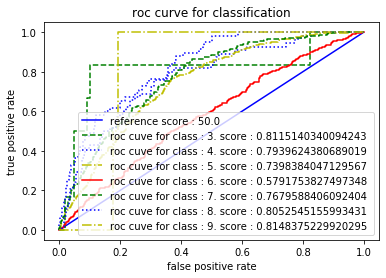

*******Evaluation Report for the model ada-boosting*************
accuracy score : 
 0.33190447030006126
confusion matrix 
 [[  0   0   3   3   0   0   0]
 [  7   0  38  10   0   0   0]
 [ 76   0 362  48   0   0   0]
 [ 97   0 456 180   0   0   0]
 [ 13   0 116 164   0   0   0]
 [  1   0  11  46   0   0   0]
 [  0   0   1   1   0   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        55
           5       0.37      0.74      0.49       486
           6       0.40      0.25      0.30       733
           7       0.00      0.00      0.00       293
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         2

    accuracy                           0.33      1633
   macro avg       0.11      0.14      0.11      1633
weighted avg       0.29      0.33      0.28      1633



C:\Users\henci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


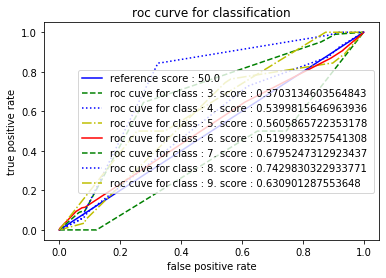

*******Evaluation Report for the model hist-boosting*************
accuracy score : 
 0.47030006123698714
confusion matrix 
 [[  0   2   0   4   0   0   0]
 [  0   6  37  12   0   0   0]
 [  0  15 310 156   5   0   0]
 [  0   5 283 399  46   0   0]
 [  0   1  41 198  52   1   0]
 [  0   0   4  38  15   1   0]
 [  0   0   1   0   1   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.21      0.11      0.14        55
           5       0.46      0.64      0.53       486
           6       0.49      0.54      0.52       733
           7       0.44      0.18      0.25       293
           8       0.50      0.02      0.03        58
           9       0.00      0.00      0.00         2

    accuracy                           0.47      1633
   macro avg       0.30      0.21      0.21      1633
weighted avg       0.46      0.47      0.44      1633



C:\Users\henci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


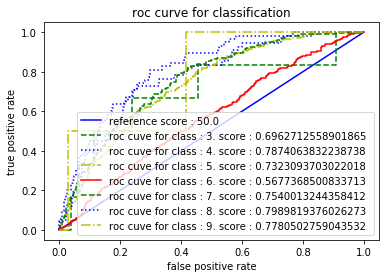

*******Evaluation Report for the model extreme-gradient-boosting*************
accuracy score : 
 0.4623392529087569
confusion matrix 
 [[  0   2   2   2   0   0   0]
 [  1   8  32  14   0   0   0]
 [  2  13 307 160   4   0   0]
 [  0   3 297 392  40   1   0]
 [  0   1  47 193  48   2   2]
 [  0   0   2  42  14   0   0]
 [  0   0   0   1   1   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.30      0.15      0.20        55
           5       0.45      0.63      0.52       486
           6       0.49      0.53      0.51       733
           7       0.45      0.16      0.24       293
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         2

    accuracy                           0.46      1633
   macro avg       0.24      0.21      0.21      1633
weighted avg       0.44      0.46      0.43      1633



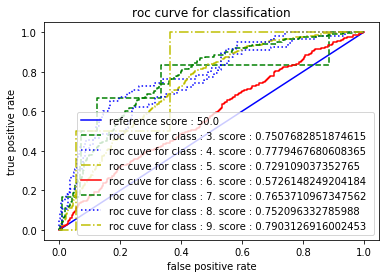

*******Evaluation Report for the model light-gbm*************
accuracy score : 
 0.4739742804654011
confusion matrix 
 [[  0   3   1   2   0   0   0]
 [  0   8  37  10   0   0   0]
 [  0   9 324 148   5   0   0]
 [  0   6 297 379  51   0   0]
 [  0   1  48 182  62   0   0]
 [  0   0   3  41  13   1   0]
 [  0   0   1   0   1   0   0]]
classification report 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.30      0.15      0.20        55
           5       0.46      0.67      0.54       486
           6       0.50      0.52      0.51       733
           7       0.47      0.21      0.29       293
           8       1.00      0.02      0.03        58
           9       0.00      0.00      0.00         2

    accuracy                           0.47      1633
   macro avg       0.39      0.22      0.22      1633
weighted avg       0.49      0.47      0.45      1633



C:\Users\henci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


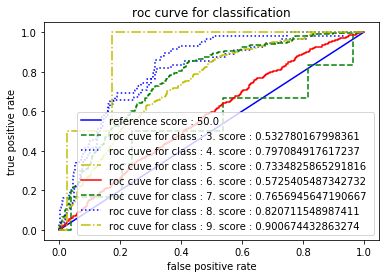

In [6]:
#load dataset
wine_dataset, wine_predictors, wine_target, wine_classes = load_wine_dataset()

#initalize model names 
model_names = ['knn','decision-tree','logistic-classifier', 'svm','random-forest',
               'bagging-classifier','naive-bayes','extra-tree-classifier', 'gradient-boosting', 'cat-boosting',
               'ada-boosting', 'hist-boosting' , 'extreme-gradient-boosting', 'light-gbm']
#model_names = [ ]

for model_name in model_names:
    create_train_predict_evaluate_single_model(wine_dataset,wine_predictors, wine_target, wine_classes, model_name)